# Minetester PPO Interpretabilty Notebook

## Policy and Image Paths

In [1]:
# Define Paths
SAVED_MODEL_PATH = "ppo_treechop-v0.model"

IMAGE_FOLDER = "screenshots/"

## Load model, define utility functions, etc...

In [2]:
#Import dependencies

import sys
import os
import numpy as np
import jax
import flax
import flax.linen as nn
import jax.numpy as jnp
import gym
import cv2

from typing import Sequence, Callable
from flax.linen.initializers import constant, orthogonal
from PIL import Image

import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

In [3]:
#Define Neural Networks

class Network(nn.Module):
    @nn.compact
    def __call__(self, x, start_at=0):
        if start_at < 1:
            x = jnp.transpose(x, (0, 2, 3, 1))
            x = x / (255.0)
            x = nn.Conv(
                32,
                kernel_size=(8, 8),
                strides=(4, 4),
                padding="VALID",
                kernel_init=orthogonal(np.sqrt(2)),
                bias_init=constant(0.0),
            )(x)
            self.sow("intermediates", "activations", x)
            self.perturb("conv0", x)

        if start_at < 2:
            x = nn.relu(x)
            x = nn.Conv(
                64,
                kernel_size=(4, 4),
                strides=(2, 2),
                padding="VALID",
                kernel_init=orthogonal(np.sqrt(2)),
                bias_init=constant(0.0),
            )(x)
            self.sow("intermediates", "activations", x)
            self.perturb("conv1", x)

        if start_at < 3:
            x = nn.relu(x)
            x = nn.Conv(
                64,
                kernel_size=(3, 3),
                strides=(1, 1),
                padding="VALID",
                kernel_init=orthogonal(np.sqrt(2)),
                bias_init=constant(0.0),
            )(x)
            self.sow("intermediates", "activations", x)
            self.perturb("conv2", x)

        x = nn.relu(x)
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(512, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0))(x)
        x = nn.relu(x)
        return x


class Critic(nn.Module):
    @nn.compact
    def __call__(self, x):
        return nn.Dense(1, kernel_init=orthogonal(1), bias_init=constant(0.0))(x)


class Actor(nn.Module):
    action_dim: Sequence[int]

    @nn.compact
    def __call__(self, x):
        return nn.Dense(self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0))(x)

In [4]:
#Load model in 

SEED=42
ACTION_DIMENSION = 36
OBS_SHAPE = (1, 4, 64, 64) # (batch, timesteps, x, y)

network = Network()
actor = Actor(action_dim=ACTION_DIMENSION)
critic = Critic()

key = jax.random.PRNGKey(SEED)

key, network_key, actor_key, critic_key = jax.random.split(key, 4)
sample_obs = np.zeros(OBS_SHAPE,dtype=np.float32)
print(sample_obs.shape)

network_params = network.init(network_key, sample_obs)
actor_params = actor.init(actor_key, network.apply(network_params, sample_obs)[0])
critic_params = critic.init(critic_key, network.apply(network_params, sample_obs)[0])

network_params, perturbations = network_params.pop("perturbations")

(1, 4, 64, 64)


In [5]:
with open(SAVED_MODEL_PATH, "rb") as f:
    (args, (network_params, actor_params, critic_params)) = flax.serialization.from_bytes(
        (None, (network_params, actor_params, critic_params)), f.read()
    )

In [6]:
#action/id mapping
#Punching is enabled by default
# mouse values are (x,y) pairs
action_mapping = {
    0:"mouse -25 -25",
    1:"mouse -25 0",
    2:"mouse -25 25",
    3:"mouse 0 -25",
    4:"mouse 0 0",#null op
    5:"mouse 0 25",
    6:"mouse 25 -25",
    7:"mouse 25 0",
    8:"mouse 25 25",
    9:"mouse -25 -25",
    10:"mouse -25 0, JUMP",
    11:"mouse -25 25, JUMP",
    12:"mouse 0 -25, JUMP",
    13:"mouse 0 0, JUMP",
    14:"mouse 0 25, JUMP",
    15:"mouse 25 -25, JUMP",
    16:"mouse 25 0, JUMP",
    17:"mouse 25 25, JUMP",
    18:"mouse -25 -25, JUMP",
    19:"mouse -25 0, FORWARD",
    20:"mouse -25 25, FORWARD",
    21:"mouse 0 -25, FORwARD",
    22:"mouse 0 0, FORWARD",
    23:"mouse 0 25, FORWARD",
    24:"mouse 25 -25, FORWARD",
    25:"mouse 25 0, FORWARD",
    26:"mouse 25 25, FORWARD",
    27:"mouse -25 -25, FORWARD, JUMP",
    28:"mouse -25 0, FORWARD, JUMP",
    29:"mouse -25 25, FORWARD, JUMP",
    30:"mouse 0 -25, FORWARD, JUMP",
    31:"mouse 0 0, FORWARD, JUMP",
    32:"mouse 0 25, FORWARD, JUMP",
    33:"mouse 25 -25 FORWARD, JUMP",
    34:"mouse 25 0, FORWARD, JUMP",
    35:"mouse 25 25, FOWARD, JUMP",
    
}
forward_mask = jnp.array([0]*18+[1]*18)
jump_mask = jnp.array(([0]*9+[1]*9)*2)
up_mask = jnp.array([1,0,0]*12)
down_mask = jnp.array([0,0,1]*12)
left_mask = jnp.array(([1]*3+[0]*6)*4)
right_mask = jnp.array(([0]*6+[1]*3)*4)

In [7]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith((".png", ".jpg", ".jpeg")):  # add more image types if necessary
            img = Image.open(os.path.join(folder, filename))
            if img is not None:
                img_arr = np.array(img)
                images.append(img_arr)
    return images

In [8]:
def plot_frames(frames):

    # Create a figure with 4 subplots, one for each frame
    fig, axs = plt.subplots(1, frames.shape[0], figsize=(12, 3))

    # Loop through each frame and plot it on a separate subplot
    for i in range(frames.shape[0]):
        axs[i].imshow(frames[i], cmap='gray')
        axs[i].axis('off')

In [9]:
def transform_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.resize(
            image, (64,64), interpolation=cv2.INTER_AREA
        )
    return image

In [10]:
# Load screen shots from folder
images = load_images_from_folder(IMAGE_FOLDER)

In [20]:
def actor_critic(x, intem_activs, output_fn):
    action_logits = actor.apply(actor_params, x)
    critic_values = critic.apply(critic_params, x)
    output = output_fn(action_logits, critic_values, x, intem_activs)
    return output

def deep_dream(init_input, output_fn, target=0, lr=1e3, n_iter=600, clip_low=0, clip_high=255):
    hidden, intem_activs = network.apply(network_params, init_input, mutable="intermediates")
    intem_activs = intem_activs["intermediates"]["activations"]
    variables = dict(network_params)
    variables["perturbations"] = perturbations


    if target > len(intem_activs):
        def forward(x):
            return actor_critic(x, None, output_fn)

        x = hidden

    else:
        def forward(x):
            x, intermediates = network.apply(variables, x, start_at=target, mutable="intermediates")
            return actor_critic(x, intermediates["intermediates"]["activations"], output_fn)

        if target == 0:
            x = init_input
        else:
            x = intem_activs[target - 1]
            
    f = jax.jit(jax.value_and_grad(forward))
    
    for i in range(n_iter):
        value, grad = f(x)
        x += lr*grad
        x = jnp.clip(x, clip_low, clip_high)
        if i % 200 == 0:
            print("Iteration:", i, "Value", value)
    
    return x

In [12]:
#Define the yaw probablity as p(turn left)-p(turn right)

def yaw_probabilty(action_logits, critic_output, network_output, layers, orientation):
    if orientation == "left":
        x = 1
    if orientation == "right":
        x = -1
    action_ps = jax.vmap(jax.nn.softmax)(action_logits)
    yaw_values = jax.vmap(lambda x: jnp.dot(left_mask,x)-jnp.dot(right_mask,x))(action_ps)
    return x*yaw_values[0]

In [33]:
def plt_raw_image(image):
    plt.imshow(image)
    plt.gca().axis('off')
    plt.show()
    
def plt_network_image(image, cmap='viridis'):
    plt.imshow(transform_image(image), cmap=cmap)
    plt.gca().axis('off')
    plt.show()
    
def plt_latent(image, channel, layer="network",cmap='viridis', is_active=False):
    a = jnp.stack([transform_image(image)]*4)[np.newaxis,...]
    hidden, intem_activs = network.apply(network_params,a,mutable="intermediates")
    intem_activs = intem_activs["intermediates"]["activations"]
    if layer == "l1":
        layer_data = intem_activs[0][0,:,:,channel]
    if layer == "l2":
        layer_data = intem_activs[1][0,:,:,channel]
    if layer == "l3":
        layer_data = intem_activs[2][0,:,:,channel]
    if layer == "network":
        layer_data = hidden.reshape(16,32)
    
    if is_active:
        plt.imshow(layer_data > 0, cmap=cmap)
    else:
        plt.imshow(layer_data, cmap=cmap)
    plt.gca().axis('off')
    plt.show()
    print("min_val:", jnp.min(layer_data), "max_val:", jnp.max(layer_data))
    print("------------------------------")
    
def plt_gradient(image, channel, output_fn, layer="network",cmap='viridis'):
    network_input = jnp.stack([transform_image(image)]*4)[np.newaxis,...]
    hidden, layers = network.apply(network_params,network_input)
    if layer == "input":
        x = network_input
    if layer == "l1":
        x = layers[0]
    if layer == "l2":
        x = layers[1]
    if layer == "l3":
        x = layers[2]
    if layer == "network":
        x = hidden
    
    _,gradient = jax.jit(network_gradient(output_fn, target=layer))(x)
    
    if layer == "network":
        gradient = gradient.reshape(1,16,32,1)
    
        
    plt.imshow(gradient[0,:,:,channel], cmap=cmap)
    plt.gca().axis('off')
    plt.show()
    print("min_val:", jnp.min(gradient[0,:,:,channel]), "max_val:", jnp.max(gradient[0,:,:,channel]))
    print("------------------------------")
    
def print_actions(image):
    a = jnp.stack([transform_image(image)]*4)[np.newaxis,...]
    network_state, layers = network.apply(network_params,a,mutable="intermediates")
    action_logits = actor.apply(actor_params,network_state)
    action_ps = jax.nn.softmax(action_logits)[0]
    
    yaw_value = jnp.dot(left_mask,action_ps)-jnp.dot(right_mask,action_ps)
    pitch_value = jnp.dot(up_mask,action_ps)-jnp.dot(down_mask,action_ps)
    jump_value = jnp.dot(jump_mask,action_ps)
    forward_value = jnp.dot(forward_mask,action_ps)
    
    print("Yaw:", yaw_value)
    print("Pitch:", pitch_value)
    print("Forward:", forward_value)
    print("Jump:", jump_value)

## Interpreting the policy

### Deep Dreaming
We can use the `deep_dream` function to probe the model for high value states and inputs that trigger particular actions

Mean brightness before optimization: 128.04979
Iteration: 0 Value -0.065314606
Iteration: 200 Value 0.35285735
Iteration: 400 Value 9.716643


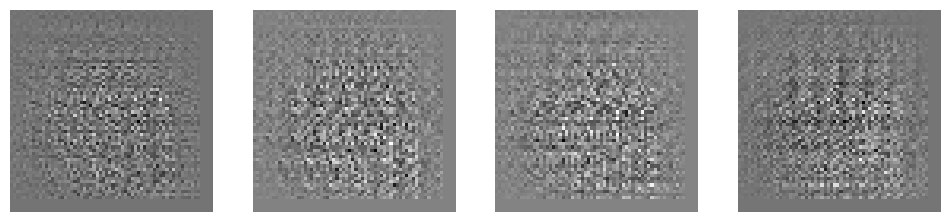

In [21]:
#Deep dreaming to find high value states

frames = jnp.array(np.random.rand(1,4,64,64), dtype=jnp.float32)*0.1+128

def get_critic(a,critic,c,d):
    return critic[0][0]
print("Mean brightness before optimization:", jnp.mean(frames))
optimized_frames = deep_dream(frames,get_critic,n_iter=500)
plot_frames(optimized_frames[0])

Iteration: 0 Value 0.03786707
Iteration: 200 Value 0.4479053
Iteration: 400 Value 0.7389254
Iteration: 0 Value -0.03786707
Iteration: 200 Value 0.25874823
Iteration: 400 Value 0.43455666


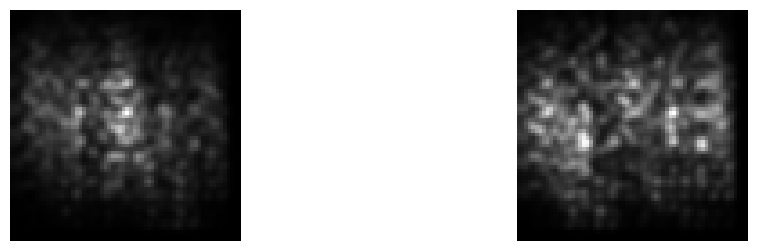

In [22]:
#Deep dreaming to find high yaw states

#Effects are clearly visible when we initialize from a roughly uniform value
frames = jnp.array(np.random.rand(1,4,64,64))*0.1+128

def f(frames):
    last_frame = frames[-1] #The last frame is most salient
    last_frame_squared = np.array((last_frame-np.mean(last_frame))**2)# Look at squared deviation
    blurred_squared_last_frame = cv2.GaussianBlur(last_frame_squared,(5,5),0) #Apply smoothing
    return blurred_squared_last_frame[np.newaxis,:,:]

optimized_frames_left = deep_dream(frames,lambda a,b,c,d: yaw_probabilty(a,b,c,d,"left"))
optimized_frames_right = deep_dream(frames,lambda a,b,c,d: yaw_probabilty(a,b,c,d,"right"))

amplitude_left = f(optimized_frames_left[0])
amplitude_right = f(optimized_frames_right[0])
output = np.concatenate([amplitude_left, amplitude_right])

plot_frames(output)

### Alignment between actor and critic

We notice that the actor an critic pay attention to the same set of features more than one would expect if their values were random.

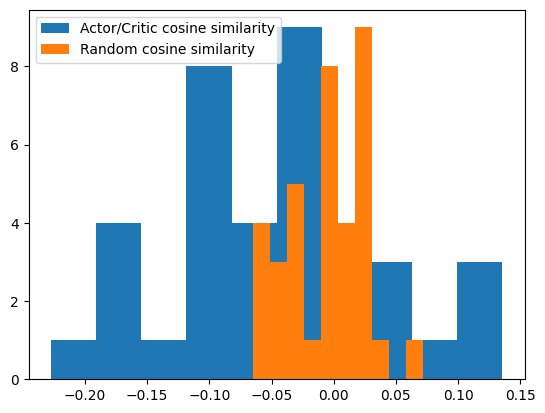

In [23]:
actor_matrix = actor_params["params"]["Dense_0"]["kernel"]
critic_vector = critic_params["params"]["Dense_0"]["kernel"]
similarity_scores = cosine_similarity(critic_vector.reshape(1, -1), actor_matrix.T)
plt.hist(similarity_scores.reshape(-1))
similarity_scores = cosine_similarity(np.random.randn(512).reshape(1, -1), actor_matrix.T)
plt.hist(similarity_scores.reshape(-1))
plt.legend(['Actor/Critic cosine similarity', 'Random cosine similarity'])

### What the model sees vs what humans see

The input image is downscaled from 600x1024x3 RGB -> 64x64 greyscale

What humans see:


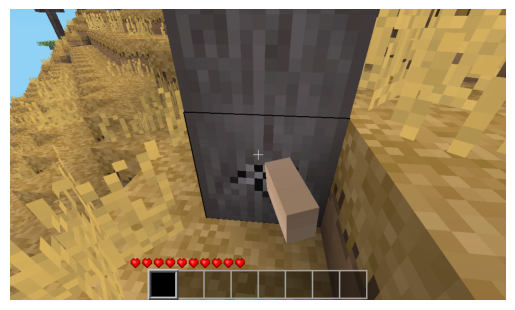

What the network sees:


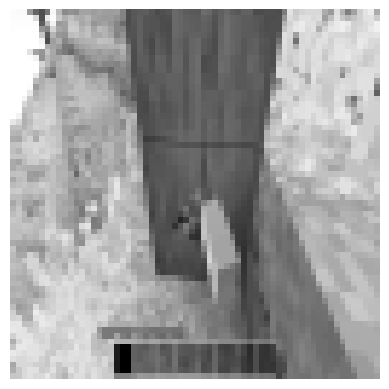

In [24]:
image_id = 12
image  = images[image_id]
print("What humans see:")
plt_raw_image(image)
print("What the network sees:")
plt_network_image(image, cmap='gray')

### The network's control system

We can see for many images with trees in them, that by mirroring the image, the sign of the yaw probablity is inverted.

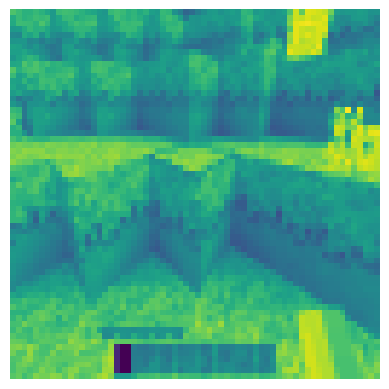

Yaw: 0.053076327
Pitch: 0.19767417
Forward: 0.46304843
Jump: 0.27462137


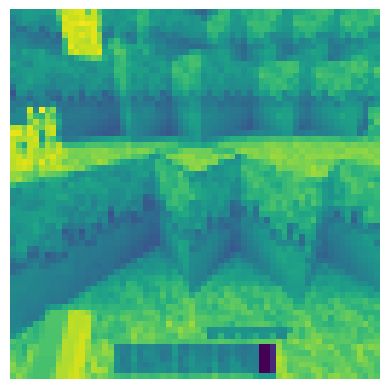

Yaw: -0.022863388
Pitch: 0.20810038
Forward: 0.46608967
Jump: 0.28506613


In [28]:
image_id = 1
image  = images[image_id]
plt_network_image(image)
print_actions(image)

image  = images[image_id][:,::-1,:]
plt_network_image(image)
print_actions(image)

### Generalization to the night

We see that the control system seems to keep working with different tree types and even at night, where colors are inverted.

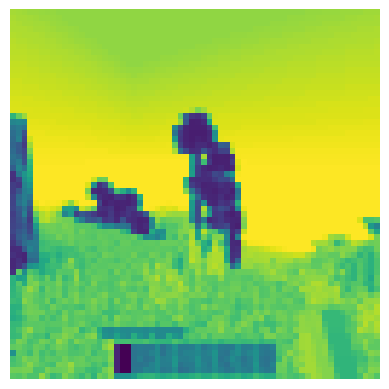

Yaw: 0.41678813
Pitch: 0.022112578
Forward: 0.71162033
Jump: 0.33234918


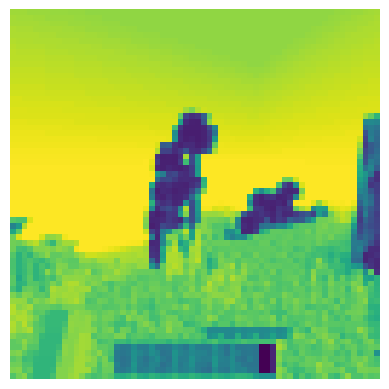

Yaw: -0.024750173
Pitch: 0.084784776
Forward: 0.7053961
Jump: 0.39439046


In [29]:
image_id = 30
image  = images[image_id]
plt_network_image(image)
print_actions(image)

image  = images[image_id][:,::-1,:]
plt_network_image(image)
print_actions(image)

### Drilling into Layer 1

We can plot the activation for typical images to see how the internal activations react. Values above 0 will cause a relu network to pass the value forward. For instance, we can see channel 21 acting as a left/right edge detector

What the network sees:


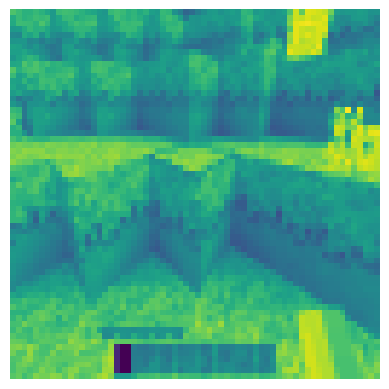

Pre ReLU activation:


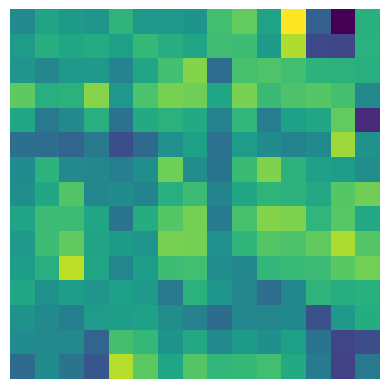

min_val: -1.0742326 max_val: 0.03649949
------------------------------
Which ReLU's get triggered:


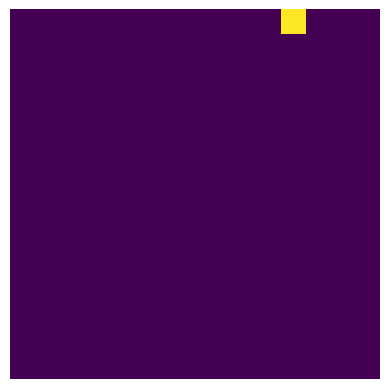

min_val: -1.0742326 max_val: 0.03649949
------------------------------


In [34]:
image_id =1
image = images[image_id]
print("What the network sees:")
plt_network_image(image)

print("Pre ReLU activation:")
plt_latent(np.array(image, dtype=np.float32),21,layer="l1")
print("Which ReLU's get triggered:")
plt_latent(np.array(image, dtype=np.float32),21,layer="l1", is_active=True)

### Tree detectors in layers 2 and 3

We found that channel 56 in layer 2 and channel 0 in layer 3 acted somewhat reliably as a tree detectors, even at night.

What the network sees:


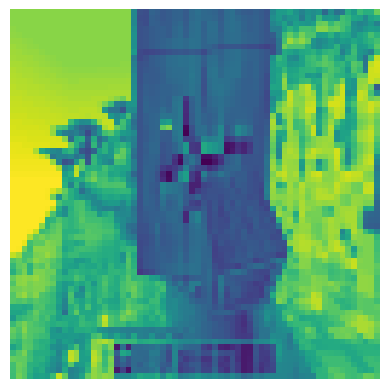

Pre ReLU activation:


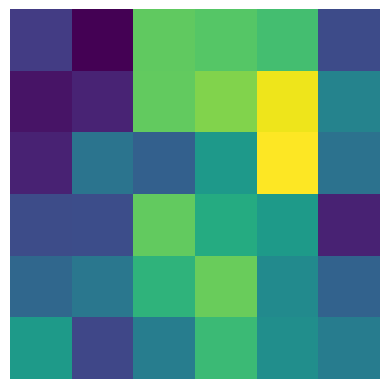

min_val: -0.60936856 max_val: 0.2161795
------------------------------
Which ReLU's get triggered:


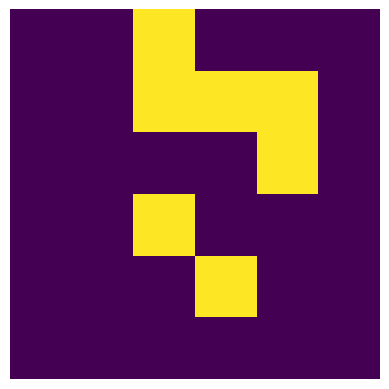

min_val: -0.60936856 max_val: 0.2161795
------------------------------


In [35]:
image_id = 15
image = images[image_id]
print("What the network sees:")
plt_network_image(image)

print("Pre ReLU activation:")
plt_latent(np.array(image, dtype=np.float32),56,layer="l2")
print("Which ReLU's get triggered:")
plt_latent(np.array(image, dtype=np.float32),56,layer="l2", is_active=True)

What the network sees:


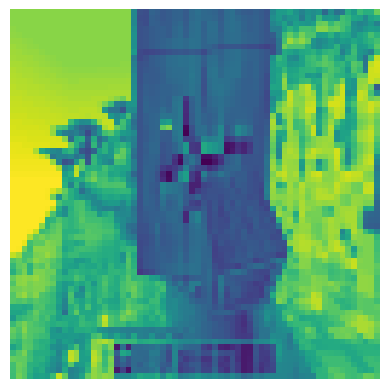

Pre ReLU activation:


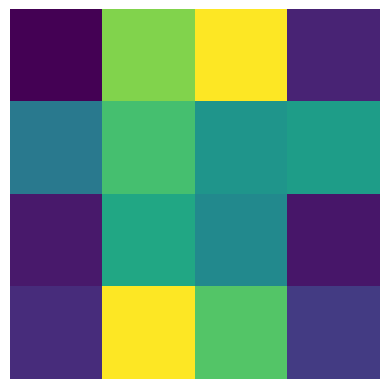

min_val: -0.41539502 max_val: 0.15593241
------------------------------
Which ReLU's get triggered:


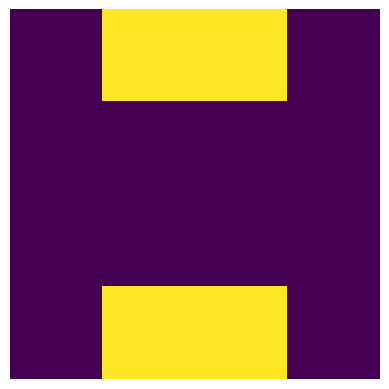

min_val: -0.41539502 max_val: 0.15593241
------------------------------


In [36]:
image_id = 15
image = images[image_id]
print("What the network sees:")
plt_network_image(image)

print("Pre ReLU activation:")
plt_latent(np.array(image, dtype=np.float32),0,layer="l3")
print("Which ReLU's get triggered:")
plt_latent(np.array(image, dtype=np.float32),0,layer="l3", is_active=True)

In [ ]:
image_id = 12
image  = images[image_id][:,::-1,:]
print("What humans see:")
plt_raw_image(image)
print("What the network sees:")
plt_network_image(image)
print("Activations:")
plt_latent(image,0,layer="l3")
print("Gradient:")
plt_gradient(image,0, lambda a,b,c,d: yaw_probabilty(a,b,c,d,"right"),layer="l3")
print_actions(image)